# Capstone Project: IBM-Coursera Professional Data Science Specialization

#####      Introduction

This project is designed to answer the question: Is there a Toronto neighbourhood that has a sufficient number of the qualities I love about my own Philadelphia, PA neighborhood - as well as a promising business environment where my firm (BECG, LLC) could be positioned for growth?

This is my project notebook. I have also submitted a report on Github, and have posted this information to my blog.

## 1. Import, install and load.

In [1]:
!pip install geopy

In [2]:
import numpy as np
import requests
from bs4 import BeautifulSoup
import urllib.request
import pandas as pd
from pandas.io.json import json_normalize

!conda install -c conda-forge geopy --yes

import matplotlib.cm as cm
import matplotlib.colors as colors

!conda install -c conda-forge folium=0.5.0 --yes
import folium

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



In [4]:
!conda update folium

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium


The following packages will be UPDATED:

    openssl:         1.1.1c-h516909a_0    conda-forge --> 1.1.1c-h7b6447c_1

The following packages will be DOWNGRADED:

    ca-certificates: 2019.6.16-hecc5488_0 conda-forge --> 2019.5.15-0      
    certifi:         2019.6.16-py36_1     conda-forge --> 2019.6.16-py36_0 

Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [ ]:
conda update conda-base

## 2.  Find data from the Web page containing Philadelphia Zip codes, scrape into Jupyter notebook

In [ ]:
#Gets the url and scrapes the html 
url = 'http://ciclt.net/sn/clt/capitolimpact/gw_ziplist.aspx?ClientCode=capitolimpact&State=pa&StName=Pennsylvania&StFIPS=42&FIPS=42101'
req = urllib.request.urlopen(url)


soup = BeautifulSoup(req)

In [ ]:
#Finds the table to scrape
table = soup.find('table')

#Provides the empty arrays for the html tags that are being grabbed and assigned to the headings
P = []
C = []

for row in table.find_all('tr'):
    cells = row.find_all('td')
    if len(cells) == 3:
        P.append(cells[0].find(text=True))
        C.append(cells[1].find(text=True))

## 3. Merge Zip code numbers into City data

In [ ]:
#Creates the dataframe and places the data in its respective columns
df_phil = pd.DataFrame(P, columns=['PostalCode'])
df_phil['City'] = C
df_phil.head(47)

In [ ]:
#A specialized function that joins the neighborhoods with the same postalcode
foo = lambda a: ','.join(a) 
df_phil = df_phil.groupby(['PostalCode']).agg({
                                'City': foo}).reset_index()

In [ ]:
df_phil.head()

## 4. Read the csv file containing latitude and longitude for each Zip code.

In [ ]:
df_lonlat = pd.read_csv('https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/download/?format=csv&refine.state=PA&q=philadelphia&timezone=America/New_York&use_labels_for_header=true', delimiter=';')
df_lonlat.head(47)


## 4A. Drop unnecessary columns

In [ ]:
df_lonlat.drop(['City', 'State', 'Timezone', 'Daylight savings time flag', 'geopoint'], axis=1, inplace=True)
df_lonlat.head()

In [ ]:
df_lonlat.rename(columns={'Zip':'PostalCode'}, inplace=True)

In [ ]:
df_phil.PostalCode = df_phil.PostalCode.astype(int)

## 5. Merge the Zip Code dataframe and the latitude / longitude dataframe.

In [ ]:
df_phil = pd.merge(df_phil, df_lonlat, on='PostalCode', how='outer')

## 6. Generate map showing Zip codes.

In [ ]:
# create map of Philadelphia using latitude and longitude values
map_phil = folium.Map(location=[39.9524152, -75.1635755], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_phil['Latitude'], df_phil['Longitude'], df_phil['City']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_phil)  
    
map_phil

### 6A. Scrape data from Web page listing Philadelphia Zip codes.

In [ ]:
#Gets the url and scrapes the html 
url1 = 'https://www.zipdatamaps.com/zipcodes-philadelphia-pa'
req1 = urllib.request.urlopen(url1)

soup1 = BeautifulSoup(req1)

### 6B. Load data into dataframe.

In [ ]:
table1 = soup1.find('table', class_='table')

Post = []
Pop = []

for row in table1.find_all('tr'):
    cells = row.find_all('td')
    if len(cells) == 8:
        Post.append(cells[0].find(text=True))
        Pop.append(cells[5].find(text=True))

In [ ]:
df_pop = pd.DataFrame(Post, columns=['PostalCode'])
df_pop['Population'] = Pop

In [ ]:
df_pop.PostalCode = df_pop.PostalCode.astype(int)

### 6C. Merge the Zip code, latitude, and longitude dataframes with population dataframe.

In [ ]:
df_merged = pd.merge(df_phil, df_pop, on='PostalCode', how='outer')

In [ ]:
%%debug
cols = [2, 3, 4, 5, ]
df_merged.drop(df_merged.columns[cols], axis=0, inplace=True)

In [ ]:
df_merged = df_merged.dropna()

In [ ]:
df_merged.head(47)

## 7. Submit Foursquare credentials

In [ ]:
# The code was removed by Watson Studio for sharing.

In [ ]:
first_nei = df_merged['PostalCode'][16]
first_nei

## 8.  We look at all Philadelphia Zip codes, using 19118 (Chestnut Hill) as a reference point.

In [ ]:
first_nei_lat = df_merged.loc[16,'Latitude']
first_nei_lon = df_merged.loc[16,'Longitude']
print('Latitude and longitude values of {} are {}, {}.'.format(first_nei, 
                                                               first_nei_lat, 
                                                               first_nei_lon))


In [ ]:
radius = 500 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    first_nei_lat, 
    first_nei_lon, 
    radius, 
    LIMIT)

In [ ]:
results = requests.get(url).json()
results

In [ ]:
results['response']['groups'][0]['items'][0]['venue']['categories'][0]['name']

In [ ]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

## 9.  Next, we gather information about the venues in Zip Code 19118 from Foursquare.

In [ ]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [ ]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]
nearby_venues

In [ ]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

## 10. We retrieve lists of venues in each Philadelphia Zip code.

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
phil_venues = getNearbyVenues(names = df_merged['PostalCode'],
                                   latitudes = df_merged['Latitude'],
                                   longitudes = df_merged['Longitude']
                                  )

In [ ]:
print(phil_venues.shape)
phil_venues.head(47)

In [ ]:
phil_venues.groupby('PostalCode').count()

In [ ]:
print('There are {} unique categories.'.format(len(phil_venues['Venue Category'].unique())))

In [ ]:
phil_onehot = pd.get_dummies(phil_venues[['Venue Category']], prefix="", prefix_sep="")

phil_onehot['PostalCode'] = phil_venues['PostalCode'] 

fixed_columns = [phil_onehot.columns[-1]] + list(phil_onehot.columns[:-1])
phil_onehot = phil_onehot[fixed_columns]
phil_onehot.head(47)

In [ ]:
phil_grouped = phil_onehot.groupby('PostalCode').mean().reset_index()
phil_grouped

In [ ]:
phil_grouped.PostalCode = phil_grouped.PostalCode.astype(str)

## 11. Identify the most common venues for each Zip code.

In [ ]:
num_top_venues = 5
for code in phil_grouped['PostalCode']:
    print("----"+code+"----")
    temp = phil_grouped[phil_grouped['PostalCode'] == code].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
phil_grouped.PostalCode = phil_grouped.PostalCode.astype(int)

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['PostalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['PostalCode'] = phil_grouped['PostalCode']

for ind in np.arange(phil_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(phil_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

## 12.  Identify clusters within the data.

In [ ]:
from sklearn.cluster import KMeans

kclusters = 5

phil_grouped_clustering = phil_grouped.drop('PostalCode', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(phil_grouped_clustering)

kmeans.labels_

In [ ]:
phil_merged = df_merged[0:47]

phil_merged['Cluster Labels'] = kmeans.labels_

phil_merged = phil_merged.join(neighborhoods_venues_sorted.set_index('PostalCode'), on='PostalCode')

phil_merged.head(47)

## 13. Generate map with clusters superimposed. 

In [ ]:
map_clusters = folium.Map(location=[39.9524152, -75.1635755], zoom_start=11)

x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)

markers_colors = []
for lat, lon, nei , cluster in zip(phil_merged['Latitude'], phil_merged['Longitude'], phil_merged['PostalCode'], phil_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [ ]:
phil_merged.loc[phil_merged['Cluster Labels'] == 0, phil_merged.columns[[0] + list(range(5, phil_merged.shape[1]))]]

In [ ]:
phil_merged.loc[phil_merged['Cluster Labels'] == 1, phil_merged.columns[[0] + list(range(5, phil_merged.shape[1]))]]

In [ ]:
phil_merged.loc[phil_merged['Cluster Labels'] == 2, phil_merged.columns[[0] + list(range(5, phil_merged.shape[1]))]]

In [ ]:
phil_merged.loc[phil_merged['Cluster Labels'] == 3, phil_merged.columns[[0] + list(range(5, phil_merged.shape[1]))]]

In [ ]:
phil_merged.loc[phil_merged['Cluster Labels'] == 4, phil_merged.columns[[0] + list(range(5, phil_merged.shape[1]))]]

## 14. Overview of results

As you can see, above, I was able to cluster Philadelphia's Zip codes using k-means clustering. However, what you might not know if you are unfamiliar with this city, the clusters make no sense. Below, you will see a Zip code map of Philadelphia, with the clusters color coded to indicate whether they fall into cluster(s) 0, 1, 2, 3, or 4. This is, in part, because Zip codes exist for the sole purpose of facilitating delivery of the mail. 

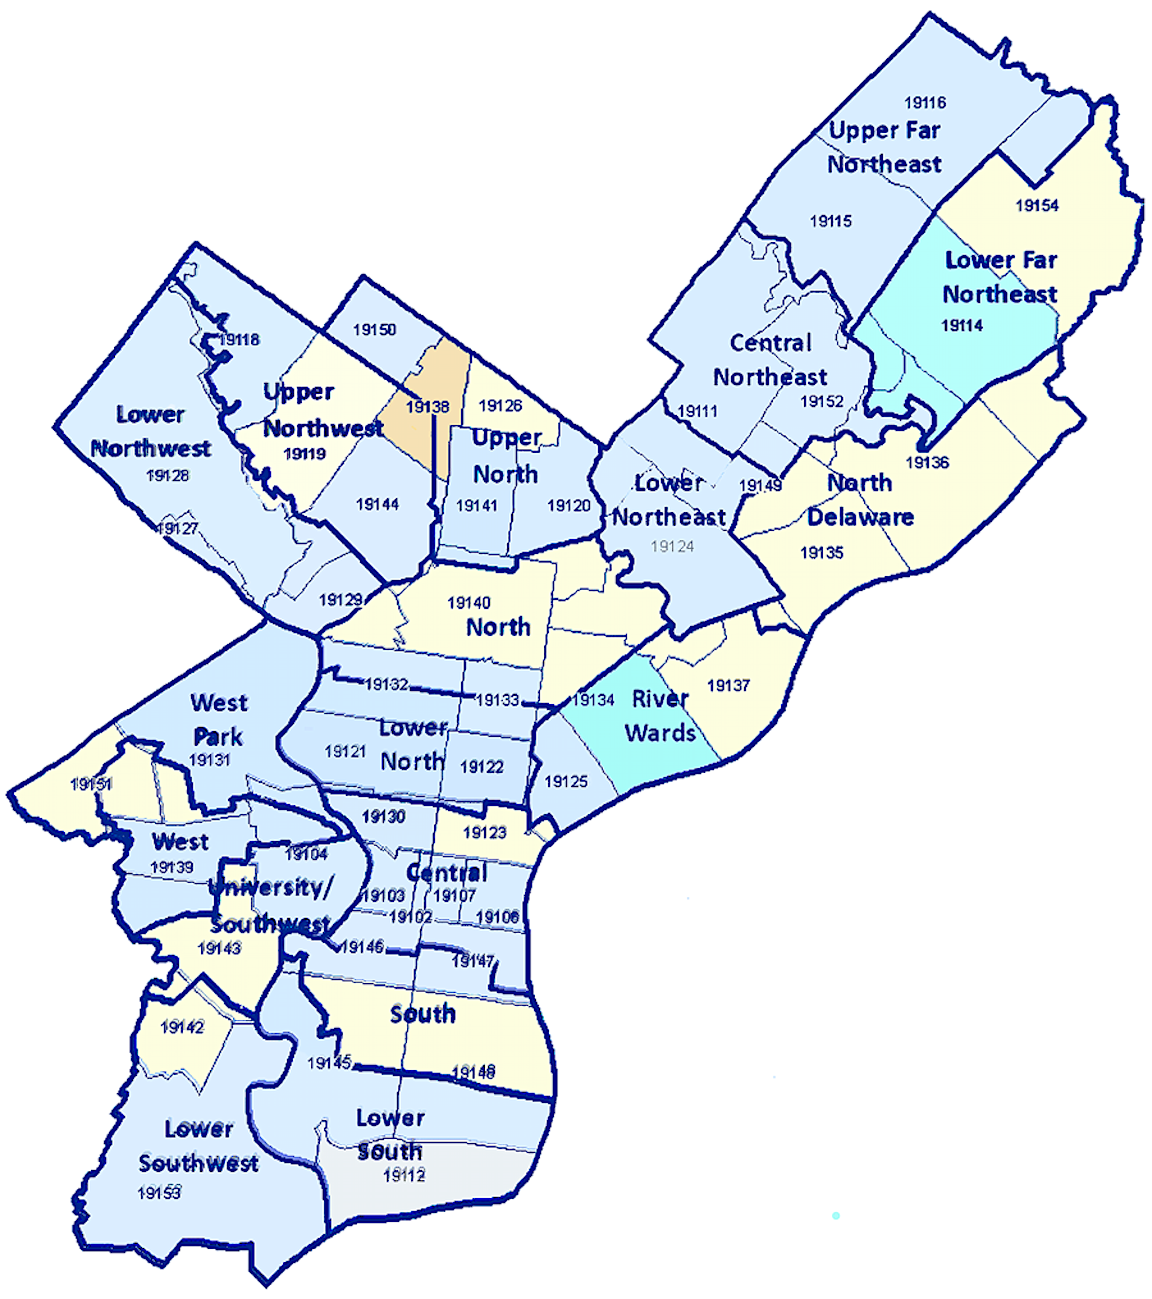

## 15. Discussion

The primary purpose of this exercise was to determine whether we were able to use what we learned during the course of this Specialization, independently and without any Lab to provide explicit instructions. In that, this project was successful. I was able to run code that produced a coherent result. I also got to learn more about my own Philadelphia neighborhood, since that was the topic upon which I chose to focus. 

Still, I set out to answer another question, which was "If I were to move to Toronto, is there a neighborhood that is similar to mine, in a location that would also be within walking distance to and area that could support a growing Consulting/Data Science business? The characteristics of such a location would include mixed residential and commercial use, in a neighborhood that is roughly as old as my own (founded before 1800), with trees and good places to go (again, on foot) as well as large business's headquarters and growing tech investment.

In both cases, I used Foursquare data to assess the number and type of venues in both cities. However, Foursquare was developed to help people pick somewhere to go, based on their wishes and their location. It was not designed to help people make momentous life decisions. That said, venues matter - and sometimes they can tell you something about a neighborhood that you might like or really not like. I found this to be the case when I first collected a list of all the venues in my neighborhood (Philadelphia's Chestnut Hill, Zip code 19118) and the Foursquare Toronto data, parsed by Zip code, latitude and longitude. Please see the spreadsheets I downloaded from my Jupyter notebook, below. 

In [5]:
# The code was removed by Watson Studio for sharing.

,Venue Number,Venue Name,Venue Category,Zip Code,Neighborhood,Latitude,Longitude
0,5,Campbell's Place,American Restaurant,19118,Chestnut Hill,40.075084,-75.204779
1,9,Chestnut Hill Grill,American Restaurant,19118,Chestnut Hill,40.074060,-75.203110
2,25,Mica,American - Fusion Restaurant,19118,Chestnut Hill,40.076777,-75.207634
3,16,Ten Thousand Villages - Chestnut Hill,Arts & Crafts Store,19118,Chestnut Hill,40.075044,-75.204678
4,6,Bredenbeck's Bakery,Bakery,19118,Chestnut Hill,40.072672,-75.202324
5,7,Cake,Bakery,19118,Chestnut Hill,40.076269,-75.206327
6,24,TD Bank,Bank,19118,Chestnut Hill,40.076596,-75.207772
7,29,Wells Fargo,Bank,19118,Chestnut Hill,40.076703,-75.206928
8,34,Artisans on the Avenue,Boutique,19118,Chestnut Hill,40.075755,-75.206156
9,2,Iron Hill Brewery & Restaurant,Brewery,19118,Chestnut Hill,40.075210,-75.205261


## Toronto Venues

In [6]:
body = client_956b1639be4e4261b6195120965e82e4.get_object(Bucket='neighborhoodsampcitiesphiladelphi-donotdelete-pr-46wtikf2skx3m1',Key='torontovenues.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_2 = pd.read_csv(body)
df_data_2.head(38)


,0,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,East Toronto,The Beaches,43.676357,-79.293031,0,Health Food Store,Trail,Pub,Wine Bar,Cuban Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant,Dog Run,Discount Store
1,2,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,Greek Restaurant,Ice Cream Shop,Italian Restaurant,Yoga Studio,Bookstore,Restaurant,Diner,Spa,Dessert Shop,Juice Bar
2,3,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,0,Park,Coffee Shop,Ice Cream Shop,Liquor Store,Light Rail Station,Burger Joint,Burrito Place,Fast Food Restaurant,Fish & Chips Shop,Italian Restaurant
3,4,East Toronto,Studio District,43.659526,-79.340923,0,Cafe,Coffee Shop,American Restaurant,Bakery,Italian Restaurant,Comfort Food Restaurant,Chinese Restaurant,Seafood Restaurant,Latin American Restaurant,Bookstore
4,5,Central Toronto,Lawrence Park,43.728020,-79.388790,0,Bus Line,Park,Swim School,Cuban Restaurant,Ethiopian Restaurant,Eastern European Restaurant,Dog Run,Discount Store,Diner,Dessert Shop
5,6,Central Toronto,Davisville North,43.712751,-79.390197,0,Grocery Store,Hotel,Gym,Clothing Store,Sandwich Place,Breakfast Spot,Food & Drink Shop,Park,Gay Bar,Gift Shop
6,7,Central Toronto,North Toronto West,43.715383,-79.405678,0,Coffee Shop,Clothing Store,Yoga Studio,Bagel Shop,Gym / Fitness Center,Fast Food Restaurant,Diner,Dessert Shop,Mexican Restaurant,Park
7,8,Central Toronto,Davisville,43.704324,-79.388790,0,Dessert Shop,Sandwich Place,Pizza Place,Coffee Shop,Italian Restaurant,Cafe,Sushi Restaurant,Costume Shop,Seafood Restaurant,Brewery
8,9,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,0,Gym,Playground,Tennis Court,Restaurant,Wine Bar,Cuban Restaurant,Ethiopian Restaurant,Eastern European Restaurant,Dog Run,Discount Store
9,10,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049,0,Pub,Coffee Shop,Fried Chicken Joint,Liquor Store,Skating Rink,Spa,Restaurant,Sports Bar,Bagel Shop,Supermarket


## 16. Implications and Conclusions

Relocation analysis is serious business, and this data collection/analysis process is a good beginning. Going forward, I plan to use it as a jumping off point for looking at neighborhoods, using units of measurement (e.g., the Census block group that are more stable and are linked with larger data sets like the Economic Census, as well as differences in governance, etc. - which are a function of differences between Canada and the US. One thing I know and like very much is Canada's approach to immigration (in other words, it is good for society, the economy, the wellbeing of all and should be encouraged).

Still, I did find a partial answer to my question of where I would want to live/work if I moved to Toronto. "Old Toronto" looks very attractive to me for so many reasons - not the least of which is the presence of the University nearby. Thriving educational institutions are essential to a good economy - especially if the type of work one does is cognitive in nature, as is the case for me. This is a pretty large area and includes a broad variety of neighborhoods. 

One of the analyses I conducted was to look at the mix of venues in my own neighborhood, then sort the Toronto data to see which among the neigborhods covered in our class's work was most similar to my own. One thing I noticed: Chestnut Hill likes food! There are several ice cream parlors and bakeries - moreseo than in many, larger neighborhoods. There is also a farmer's market, and two of the three grocery grocery stores are organic. There are numerous parkes, one of which is among the largest in the US, and there are two light commuter rail lines. Among the Toronto Postal Codes we looked at, the Toronto neighbourhood called "Harbord, near the University of Toronto, seems to have all of these things. Yes, more research is required, but now I have more and better tools at my disposal. 

## Thank you for your time and interest. I appreciate it!